In [135]:
import os
import pdb
import h5py
import pickle
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

# Config

In [49]:
geuvadis_eQTL_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/analysis_results"
geuvadis_genotypes_dir = "/clusterfs/nilah/Geuvadis/E-GEUV-1/genotypes/"
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
models_dir = "/global/scratch/users/aniketh/finetune-enformer/saved_models/"
test_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/test_preds_final/"

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
BASELINE_PREDS_PATH = (
    "../baseline/baseline_enformer.384_bins.rc.csv"
)
PREDIXCAN_PREDS_PATH = "../predixcan_lite/h5_bins_384_chrom_split/384_bins_no_cv/preds.csv"

all_main_run_names={
    # "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
#     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    # "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    # "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
}
all_seeds = [42, 97, 7]
train_h5 = h5py.File(train_h5_path, "r")
context_size = train_h5["seqs"][0].shape[1]
train_h5.close()

In [3]:
ALL_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    for i, seed in enumerate(all_seeds):
        train_cmd_template = all_main_run_names[run]
        lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[0]
        wd_used_during_training = train_cmd_template.split("--weight_decay ")[-1].split(" ")[0]
        rcprob_used_during_training = 0.5
        rsmax_used_during_training = 3
            
        model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
        ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)

test_h5 = h5py.File(test_h5_path, "r")

# Read test set predictions and compute correlations

In [4]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df


def load_finetuned_preds(PREDS_PATH):
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    ancestries_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    ancestries = test_h5["ancestries"][:].astype(str)
    for (pred, gene, sample, ancestry) in zip(preds, genes, samples, ancestries):
        preds_by_gene[gene][sample] = pred
        ancestries_by_gene[gene][sample] = ancestry
    return preds_by_gene, ancestries_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df):
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values.astype("float32")
        assert np.isnan(gene_preds).sum() == 0
        assert np.isnan(gene_counts).sum() == 0
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan pearsonR")
            corrs[g] = 0
            
    return corrs


def compare_to_geuvadis_counts(finetuned_preds, geuvadis_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    gene_preds = [finetuned_preds[gene][s] for s in samples]
    gene_counts = geuvadis_df.loc[gene, samples].values
    ax.scatter(gene_counts, gene_preds)
    ax.set(
        xlabel="Geuvadis counts",
        ylabel="finetuned predictions",
        title=f"Correlation: {pearsonr(gene_preds, gene_counts)[0]:.3f}",
    )


def compare_to_baseline_counts(finetuned_preds, baseline_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    baseline_preds = baseline_df[gene][samples].values
    finetuned_preds = [finetuned_preds[gene][s] for s in samples]
    ax.scatter(baseline_preds, finetuned_preds)
    ax.set(
        xlabel="baseline predictions",
        ylabel="finetuned predictions",
        title=f"Correlation: {pearsonr(baseline_preds, finetuned_preds)[0]:.3f}",
    )


def load_other_model_preds_df(preds_df_path):
    preds_df = pd.read_csv(preds_df_path, index_col=0).T
    return preds_df


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds):
    corrs = {}
    for g in finetuned_preds:
        if g not in preds_df.columns:
            print(f"Gene {g} has no predictions/counts and thus has a nan PearsonR")
            corrs[g] = 0
            continue
        
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan PearsonR")
            corrs[g] = 0
            
    return corrs


def compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene, abs_corrs: bool = False
):
    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    baseline_corrs_l = [baseline_corrs[g] for g in genes]
    
    gene_class = []
    for g in genes:
        temp = np.array([ancestries_by_gene[g][key] for key in ancestries_by_gene[g]])
        if (temp != "Yoruba").sum() == 0:
            gene_class.append("yri_split")
        elif len(finetuned_preds[g]) <= 77:
            gene_class.append("random_split")
        else:
            gene_class.append("unseen")
    
    df = pd.DataFrame(
        {
            "gene": genes,
            "finetuned Pearson": np.abs(finetuned_corrs_l) 
            if abs_corrs 
            else finetuned_corrs_l,
            "baseline Pearson": np.abs(baseline_corrs_l)
            if abs_corrs
            else baseline_corrs_l,
            "gene_class": gene_class,
        }
    )

    ax = sns.scatterplot(
        data=df,
        x="baseline Pearson",
        y="finetuned Pearson",
        hue="gene_class",
    )
    ax.set_ylabel("|finetuned Pearson|" if abs_corrs else "finetuned Pearson")
    ax.set_xlabel("|baseline Pearson|" if abs_corrs else "baseline Pearson")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set(aspect="equal", xlim=lims, ylim=lims)
    
    ax.axhline(
        df[df["gene_class"] == "random_split"]["finetuned Pearson"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )
    ax.axvline(
        df[df["gene_class"] == "random_split"]["baseline Pearson"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )

    ax.axhline(
        df[df["gene_class"] == "yri_split"]["finetuned Pearson"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    ax.axvline(
        df[df["gene_class"] == "yri_split"]["baseline Pearson"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    
    ax.axhline(
        df[df["gene_class"] == "unseen"]["finetuned Pearson"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    ax.axvline(
        df[df["gene_class"] == "unseen"]["baseline Pearson"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    
    summary = {}
    
    for split in ["random_split", "yri_split", "unseen"]:
        print(f"Split {split}, n_samples = {(df['gene_class'] == split).sum()}")
        print(f"Baseline PearsonR = {df[df['gene_class'] == split]['baseline Pearson'].mean()}")
        print(f"Finetuned PearsonR = {df[df['gene_class'] == split]['finetuned Pearson'].mean()}")
        print()
        
        summary["Baseline " + split] = df[df['gene_class'] == split]['baseline Pearson'].mean()
        summary["Finetuned " + split] = df[df['gene_class'] == split]['finetuned Pearson'].mean()

    plt.show()
    return summary

In [5]:
geuvadis_df = load_geuvadis_data()
baseline_df = load_other_model_preds_df(BASELINE_PREDS_PATH)
predixcan_df = load_other_model_preds_df(PREDIXCAN_PREDS_PATH)

In [6]:
gene_perf = {}

for model in ALL_PREDS_PATHS:
    PREDS_PATH = ALL_PREDS_PATHS[model]
    finetuned_preds, ancestries_by_gene = load_finetuned_preds(PREDS_PATH)
    finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)
    baseline_corrs = get_other_model_corrs(baseline_df, geuvadis_df, finetuned_preds)
    predixcan_corrs = get_other_model_corrs(predixcan_df, geuvadis_df, finetuned_preds)

    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    baseline_corrs_l = [baseline_corrs[g] for g in genes]
    predixcan_corrs_l = [predixcan_corrs[g] for g in genes]
    
    gene_class = []
    for g in genes:
        temp = np.array([ancestries_by_gene[g][key] for key in ancestries_by_gene[g]])
        if (temp != "Yoruba").sum() == 0:
            gene_class.append("yri_split")
        elif len(finetuned_preds[g]) <= 77:
            gene_class.append("random_split")
        else:
            gene_class.append("unseen")

    if "gene" not in gene_perf:
        gene_perf["gene"] = genes
        gene_perf["gene_class"] = gene_class
        gene_perf["baseline_Pearson"] = baseline_corrs_l
        gene_perf["predixcan_Pearson"] = predixcan_corrs_l
        gene_perf = pd.DataFrame(gene_perf)
    
    df = pd.DataFrame(
        {
            "gene": genes,
            f"finetuned_Pearson_{model}": finetuned_corrs_l            
        }
    )

    gene_perf = gene_perf.merge(df, on="gene", how="inner", validate="one_to_one")

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene csta has invalid predictions/counts and thus has a nan PearsonR
Gene hadh has invalid predictions/counts and thus has a nan PearsonR
Gene prune2 has invalid predictions/counts and thus has a nan PearsonR
Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene csta has invalid predictions/counts and thus has a nan PearsonR
Gene hadh has invalid predictions/counts and thus has a nan PearsonR
Gene prune2 has invalid predictions/counts and thus has a nan PearsonR
Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene csta has invalid predictions/counts and thus has a nan PearsonR
Gene hadh has invalid predictions/counts and thus has a nan PearsonR
Gene prune2 has invalid predictions/counts and thus has a nan PearsonR
Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and 

In [7]:
gene_perf["Mean Pearson Correlation"] = 0
for model in ALL_PREDS_PATHS:
    gene_perf["Mean Pearson Correlation"] += gene_perf[f"finetuned_Pearson_{model}"]
gene_perf["Mean Pearson Correlation"] /= len(ALL_PREDS_PATHS)
gene_perf

,gene,gene_class,baseline_Pearson,predixcan_Pearson,finetuned_Pearson_regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,Mean Pearson Correlation
0,znf83,random_split,-0.002427,0.343012,0.359325,0.438791,0.335123,0.377746
1,eftud2,random_split,-0.031810,0.382342,0.345252,0.406891,0.377886,0.376677
2,tspan4,random_split,0.187472,0.314566,0.258073,0.320718,0.341329,0.306707
3,nucb1,random_split,0.424683,0.172031,0.423714,0.320159,0.376667,0.373514
4,rflnb,random_split,0.109537,0.174086,0.224607,0.162975,0.171352,0.186311
...,...,...,...,...,...,...,...,...
495,rmc1,unseen,-0.142521,0.000000,0.209284,0.281193,-0.160249,0.110076
496,gdpgp1,unseen,-0.014475,0.000000,0.006842,0.010706,-0.157538,-0.046663
497,oprl1,unseen,-0.038615,0.000000,0.107164,0.071845,0.089864,0.089624
498,catsper2,unseen,-0.215897,0.000000,0.184256,0.206878,0.140611,0.177248


### Compute the percent of all variants seen during training

In [8]:
train_h5 = h5py.File(train_h5_path, "r")
train_genes = train_h5["genes"][:].astype(str)

val_h5 = h5py.File(val_h5_path, "r")
val_genes = val_h5["genes"][:].astype(str)

test_genes = test_h5["genes"][:].astype(str)

if not os.path.exists("gene_variant_stats.csv"):
    all_percent_seen_during_training = []
    all_num_train_variants = []
    all_percent_only_seen_during_testing = []
    all_num_only_test = []
    all_num_all_variants = []
    
    for i in tqdm(range(len(gene_perf))):
        row = gene_perf.iloc[i]
        gene_name = row["gene"]
        gene_class = row["gene_class"]
        print(gene_name, gene_class)
        train_gene_seqs = train_h5["seqs"][train_genes == gene_name]
        val_gene_seqs = val_h5["seqs"][val_genes == gene_name]
        test_gene_seqs = test_h5["seqs"][test_genes == gene_name]
    
        # get variants in each split
        train_variants = np.any(train_gene_seqs > 0, axis=(0, 1)) # (seqlen, 4)
        val_variants = np.any(val_gene_seqs > 0, axis=(0, 1))
        test_variants = np.any(test_gene_seqs > 0, axis=(0, 1))
    
        # get all variants
        all_variants = np.stack([train_variants, val_variants, test_variants])
        all_variants = np.any(all_variants, axis=0)
        num_all_variants = (all_variants.sum(-1) > 1).sum()
    
        # compute percent of variants seen in the training set
        # this XOR will find variants that are not present in the train set but are found in the val or test set
        if gene_class == "unseen":
            all_percent_seen_during_training.append(0)
            all_num_train_variants.append(0)
            all_num_all_variants.append(num_all_variants)
            all_percent_only_seen_during_testing.append(100.0)
            all_num_only_test.append(num_all_variants)
        else:
            num_not_seen_in_train = np.logical_xor(all_variants, train_variants).sum()
            num_seen_in_train = num_all_variants - num_not_seen_in_train
            percent_seen_during_training = (num_seen_in_train / num_all_variants) * 100.0
            assert percent_seen_during_training >= 0
            print(f"Num all variants = {num_all_variants}")
            print(f"Num variants seen during training = {num_seen_in_train} ({percent_seen_during_training}%)")
            
            all_percent_seen_during_training.append(percent_seen_during_training)
            all_num_train_variants.append(num_seen_in_train)
            all_num_all_variants.append(num_all_variants)
    
            # compute percent of variants that are only seen in the test set
            # this op will find variants that are present in the test set but are not found in the val or test set
            num_only_seen_in_test = (test_variants & np.logical_not(train_variants | val_variants)).sum()
            percent_only_seen_during_testing = (num_only_seen_in_test / num_all_variants) * 100.0
            print(f"Num variants only seen during testing = {num_only_seen_in_test} ({percent_only_seen_during_testing}%)")
        
            all_percent_only_seen_during_testing.append(percent_only_seen_during_testing)
            all_num_only_test.append(num_only_seen_in_test)
    
    gene_perf["Percent of all variants seen during training"] = all_percent_seen_during_training
    gene_perf["Num variants seen during training"] = all_num_train_variants
    
    gene_perf["Percent of all variants only seen during testing"] = all_percent_only_seen_during_testing
    gene_perf["Num variants only seen during testing"] = all_num_only_test
    
    gene_perf["Num variants"] = all_num_all_variants
    
    gene_perf[gene_perf.columns[:2].tolist() + gene_perf.columns[-6:].tolist()].to_csv("gene_variant_stats.csv", index=False)

gene_variant_stats = pd.read_csv("gene_variant_stats.csv")

In [9]:
gene_variant_stats

,gene,gene_class,Mean Pearson Correlation,Percent of all variants seen during training,Num variants seen during training,Percent of all variants only seen during testing,Num variants only seen during testing,Num variants
0,znf83,random_split,0.377746,98.021309,644,1.369863,9,657
1,eftud2,random_split,0.376677,96.728972,414,2.570093,11,428
2,tspan4,random_split,0.306707,94.072658,492,5.162524,27,523
3,nucb1,random_split,0.373514,96.153846,525,3.296703,18,546
4,rflnb,random_split,0.186311,97.192982,277,2.456140,7,285
...,...,...,...,...,...,...,...,...
495,rmc1,unseen,0.110076,0.000000,0,100.000000,405,405
496,gdpgp1,unseen,-0.046663,0.000000,0,100.000000,571,571
497,oprl1,unseen,0.089624,0.000000,0,100.000000,370,370
498,catsper2,unseen,0.177248,0.000000,0,100.000000,95,95


## Find strongest eQTL within context window

In [86]:
if not os.path.exists(os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv")):
    geuvadis_id_to_dbSNP_id = pd.read_csv(os.path.join(geuvadis_genotypes_dir, "Phase1.Geuvadis_dbSnp137_idconvert.txt.gz"), names=["dbSNP_id", "geuvadis_id"], sep="\t")
    geuvadis_id_annotations = pd.read_csv(os.path.join(geuvadis_genotypes_dir, "ALL.phase1_release_v3.20101123.snps_indels_sv.sites.gdid.gdannot.v2.vcf.gz"), skiprows=78, sep="\t")
    geuvadis_id_annotations = geuvadis_id_annotations.merge(geuvadis_id_to_dbSNP_id, left_on="ID", right_on="geuvadis_id", how="inner")
    
    EUR_all_eQTLs_path = os.path.join(geuvadis_eQTL_dir, "EUR373.gene.cis.FDR5.all.rs137.txt.gz")
    YRI_all_eQTLs_path = os.path.join(geuvadis_eQTL_dir, "YRI89.gene.cis.FDR5.all.rs137.txt.gz")
    
    EUR_all_eQTLs = pd.read_csv(EUR_all_eQTLs_path, sep="\t")
    EUR_all_eQTLs = EUR_all_eQTLs[EUR_all_eQTLs["distance"] < (context_size // 2)].reset_index(drop=True)
    EUR_all_eQTLs["abs_rvalue"] = np.abs(EUR_all_eQTLs["rvalue"])
    EUR_all_eQTLs["stable_id"] = EUR_all_eQTLs.apply(lambda x: x["GENE_ID"].split(".")[0], axis=1)
    EUR_all_eQTLs = EUR_all_eQTLs.sort_values(by=["GENE_ID", "abs_rvalue"], ascending=[True, False]).reset_index(drop=True)
    
    YRI_all_eQTLs = pd.read_csv(YRI_all_eQTLs_path, sep="\t")
    YRI_all_eQTLs = YRI_all_eQTLs[YRI_all_eQTLs["distance"] < (context_size // 2)].reset_index(drop=True)
    YRI_all_eQTLs["abs_rvalue"] = np.abs(YRI_all_eQTLs["rvalue"])
    YRI_all_eQTLs["stable_id"] = YRI_all_eQTLs.apply(lambda x: x["GENE_ID"].split(".")[0], axis=1)
    YRI_all_eQTLs = YRI_all_eQTLs.sort_values(by=["GENE_ID", "abs_rvalue"], ascending=[True, False]).reset_index(drop=True)
    
    EUR_all_eQTLs = EUR_all_eQTLs.merge(geuvadis_id_annotations[["dbSNP_id", "geuvadis_id", "#CHROM", "POS", "REF", "ALT", "INFO"]], left_on="SNP_ID", right_on="dbSNP_id", how="inner")
    YRI_all_eQTLs = YRI_all_eQTLs.merge(geuvadis_id_annotations[["dbSNP_id", "geuvadis_id", "#CHROM", "POS", "REF", "ALT", "INFO"]], left_on="SNP_ID", right_on="dbSNP_id", how="inner")
    
    GEUVADIS_COUNTS = pd.read_csv(GEUVADIS_COUNTS_PATH)
    EUR_all_eQTLs = EUR_all_eQTLs.merge(GEUVADIS_COUNTS[["stable_id", "our_gene_name"]], on="stable_id", how="inner")
    YRI_all_eQTLs = YRI_all_eQTLs.merge(GEUVADIS_COUNTS[["stable_id", "our_gene_name"]], on="stable_id", how="inner")
    
    EUR_eQTLs_within_context_for_selected_genes = gene_perf.merge(EUR_all_eQTLs, left_on="gene", right_on="our_gene_name", how="inner")
    EUR_eQTLs_within_context_for_selected_genes = EUR_eQTLs_within_context_for_selected_genes[EUR_eQTLs_within_context_for_selected_genes.columns[8:]]
    EUR_eQTLs_within_context_for_selected_genes.to_csv(os.path.join(data_dir, "EUR_eQTLs_within_context_for_selected_genes.csv"), index=False)
    
    YRI_eQTLs_within_context_for_selected_genes = gene_perf.merge(YRI_all_eQTLs, left_on="gene", right_on="our_gene_name", how="inner")
    YRI_eQTLs_within_context_for_selected_genes = YRI_eQTLs_within_context_for_selected_genes[YRI_eQTLs_within_context_for_selected_genes.columns[8:]]
    YRI_eQTLs_within_context_for_selected_genes.to_csv(os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv"), index=False)

EUR_eQTLs_within_context_for_selected_genes = pd.read_csv(os.path.join(data_dir, "EUR_eQTLs_within_context_for_selected_genes.csv"))
YRI_eQTLs_within_context_for_selected_genes = pd.read_csv(os.path.join(data_dir, "YRI_eQTLs_within_context_for_selected_genes.csv"))

top_EUR_eQTL_for_every_gene = EUR_eQTLs_within_context_for_selected_genes.groupby("our_gene_name").head(1).reset_index(drop=True)
top_YRI_eQTL_for_every_gene = YRI_eQTLs_within_context_for_selected_genes.groupby("our_gene_name").head(1).reset_index(drop=True)

In [167]:
top_eQTL_AFs = []
for i in tqdm(range(len(top_EUR_eQTL_for_every_gene))):
    row = top_EUR_eQTL_for_every_gene.iloc[i]
    af = float(row["INFO"].split(";EUR_AF=")[-1].split(";")[0])
    af = min(af, 1 - af)
    top_eQTL_AFs.append(af)

top_EUR_eQTL_for_every_gene["EUR_AF"] = top_eQTL_AFs

100%|██████████| 383/383 [00:00<00:00, 15274.93it/s]


# Random split genes analyses

In [168]:
random_split_gene_perf = gene_perf[gene_perf["gene_class"] == "random_split"].copy().reset_index(drop=True)

## Performance vs. PrediXcan performance

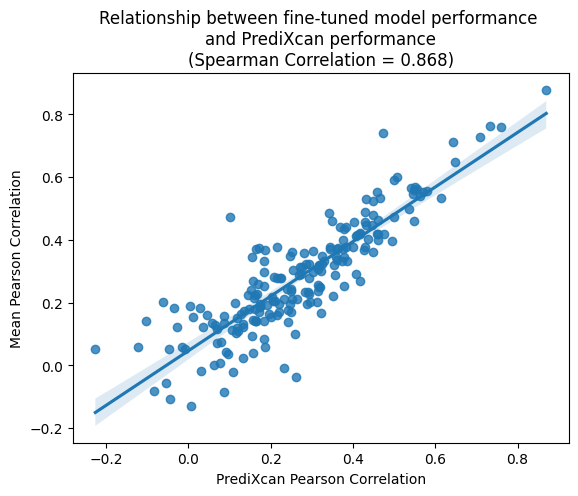

In [169]:
spr = spearmanr(random_split_gene_perf["predixcan_Pearson"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["predixcan_Pearson"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="predixcan_Pearson", 
            y="Mean Pearson Correlation")
plt.xlabel("PrediXcan Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand PrediXcan performance\n(Spearman Correlation = {spr.round(3)})")
plt.show()

## Performance vs. distance of strongest eQTL within context window to TSS

In [170]:
EUR_top_eQTLs_path = os.path.join(geuvadis_eQTL_dir, "EUR373.gene.cis.FDR5.best.rs137.txt.gz")
YRI_top_eQTLs_path = os.path.join(geuvadis_eQTL_dir, "YRI89.gene.cis.FDR5.best.rs137.txt.gz")

EUR_top_eQTLs = pd.read_csv(EUR_top_eQTLs_path, sep="\t", names=["SNP_ID", "ID", "GENE_ID", "PROBE_ID", 
                                                                 "CHR_SNP", "CHR_GENE", "SNPpos", "TSSpos", 
                                                                 "Absolute_Distance_from_TSS", "rvalue", "pvalue", "log10pvalue"])
YRI_top_eQTLs = pd.read_csv(YRI_top_eQTLs_path, sep="\t", names=["SNP_ID", "ID", "GENE_ID", "PROBE_ID", 
                                                                 "CHR_SNP", "CHR_GENE", "SNPpos", "TSSpos", 
                                                                 "Absolute_Distance_from_TSS", "rvalue", "pvalue", "log10pvalue"])

GEUVADIS_COUNTS = pd.read_csv(GEUVADIS_COUNTS_PATH)

In [171]:
top_EUR_eQTL_for_every_gene.columns

Index(['SNP_ID', 'ID', 'GENE_ID', 'PROBE_ID', 'CHR_SNP', 'CHR_GENE', 'SNPpos',
       'TSSpos', 'distance', 'rvalue', 'pvalue', 'log10pvalue', 'abs_rvalue',
       'stable_id', 'dbSNP_id', 'geuvadis_id', '#CHROM', 'POS', 'REF', 'ALT',
       'INFO', 'our_gene_name', 'EUR_AF'],
      dtype='object')

In [172]:
# random_split_gene_perf = random_split_gene_perf.merge(GEUVADIS_COUNTS[["our_gene_name", "top_EUR_eqtl_rsid", "top_YRI_eqtl_rsid", "top_EUR_eqtl_distance", "top_YRI_eqtl_distance"]], 
#                                                       left_on="gene", right_on="our_gene_name", how="inner").drop("our_gene_name", axis=1)
random_split_gene_perf = random_split_gene_perf.merge(top_EUR_eQTL_for_every_gene[["our_gene_name", "abs_rvalue", "pvalue", "log10pvalue", 'distance', '#CHROM', 'POS', 'REF', 'ALT', "EUR_AF"]], 
                                                      left_on="gene", right_on="our_gene_name", how="inner").drop("our_gene_name", axis=1)

random_split_gene_perf

,gene,gene_class,baseline_Pearson,predixcan_Pearson,finetuned_Pearson_regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,Mean Pearson Correlation,abs_rvalue,pvalue,log10pvalue,distance,#CHROM,POS,REF,ALT,EUR_AF
0,znf83,random_split,-0.002427,0.343012,0.359325,0.438791,0.335123,0.377746,0.350876,3.071768e-12,11.512612,21962.0,19,53171779,G,T,0.11
1,eftud2,random_split,-0.031810,0.382342,0.345252,0.406891,0.377886,0.376677,0.268721,1.374719e-07,6.861786,13347.0,17,42990340,C,T,0.37
2,tspan4,random_split,0.187472,0.314566,0.258073,0.320718,0.341329,0.306707,0.239146,3.006855e-06,5.521888,5146.5,11,837661,GT,G,0.40
3,nucb1,random_split,0.424683,0.172031,0.423714,0.320159,0.376667,0.373514,0.238053,3.345370e-06,5.475556,1248.0,19,49402059,C,A,0.28
4,calm3,random_split,-0.027166,0.153913,0.122829,0.112955,0.042417,0.092734,0.272128,9.398158e-08,7.026957,3158.0,19,47101408,G,A,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,mri1,random_split,-0.018565,0.498632,0.507127,0.497753,0.413111,0.472664,0.513628,1.849813e-26,25.732872,2771.5,19,13872565,TC,T,0.41
156,rdh13,random_split,-0.114664,0.291643,0.290581,0.190437,0.219787,0.233602,0.357029,1.200900e-12,11.920493,6511.0,19,55574403,C,G,0.16
157,cdc37,random_split,0.225859,0.250160,0.035548,0.249744,0.228735,0.171342,0.236770,3.789474e-06,5.421421,7351.0,19,10521620,ATTAT,A,0.28
158,fcrl3,random_split,0.391737,0.436433,0.382754,0.411078,0.417283,0.403705,0.356370,1.329187e-12,11.876414,1782.0,1,157668993,C,T,0.47


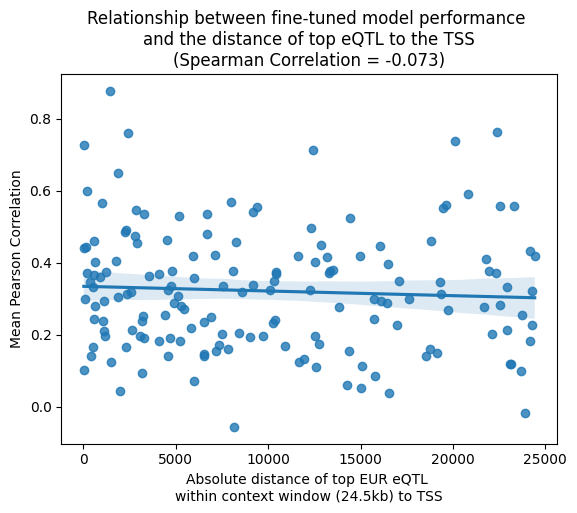

In [173]:
# spr = spearmanr(random_split_gene_perf["top_EUR_eqtl_distance"], 
#                 random_split_gene_perf["Mean Pearson Correlation"])[0]
# pr = pearsonr(random_split_gene_perf["top_EUR_eqtl_distance"], 
#               random_split_gene_perf["Mean Pearson Correlation"])[0]

spr = spearmanr(random_split_gene_perf["distance"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["distance"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="distance", 
            y="Mean Pearson Correlation")
plt.xlabel("Absolute distance of top EUR eQTL \nwithin context window (24.5kb) to TSS")
plt.title(f"Relationship between fine-tuned model performance \nand the distance of top eQTL to the TSS\n(Spearman Correlation = {spr.round(3)})")
plt.show()

## Performance vs. log10p-val of strongest eQTL within context window

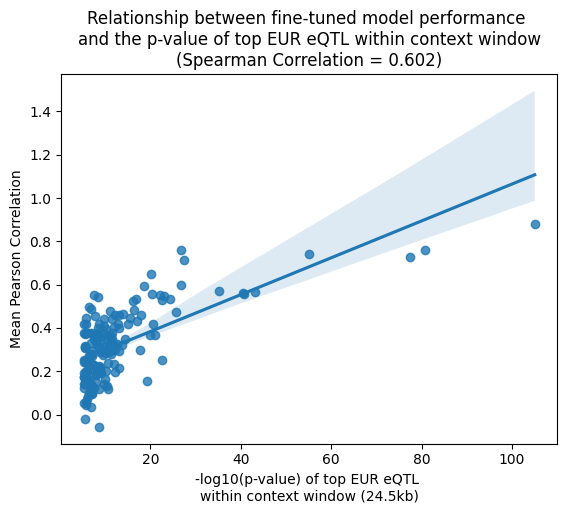

In [174]:
spr = spearmanr(random_split_gene_perf["log10pvalue"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["log10pvalue"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="log10pvalue", 
            y="Mean Pearson Correlation")
plt.xlabel("-log10(p-value) of top EUR eQTL \nwithin context window (24.5kb)")
plt.title(f"Relationship between fine-tuned model performance \nand the p-value of top EUR eQTL within context window\n(Spearman Correlation = {spr.round(3)})")
plt.show()

## Performance vs. EUR allele frequency of strongest eQTL within context window

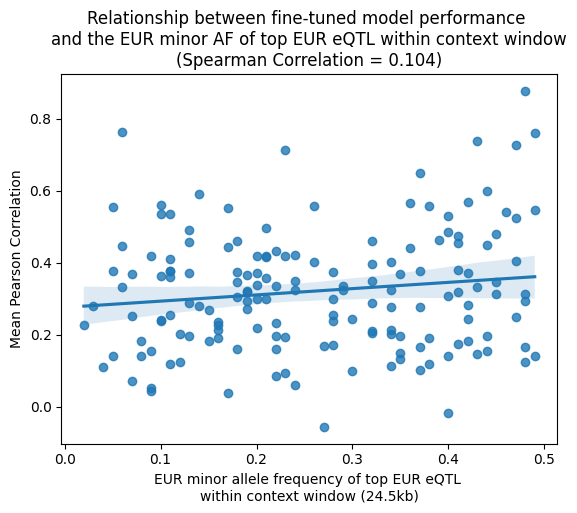

In [176]:
spr = spearmanr(random_split_gene_perf["EUR_AF"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["EUR_AF"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="EUR_AF", 
            y="Mean Pearson Correlation")
plt.xlabel("EUR minor allele frequency of top EUR eQTL \nwithin context window (24.5kb)")
plt.title(f"Relationship between fine-tuned model performance \nand the EUR minor AF of top EUR eQTL within context window\n(Spearman Correlation = {spr.round(3)})")
plt.show()

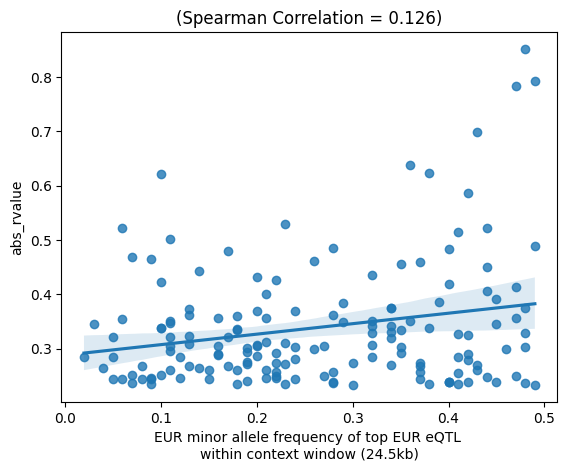

In [177]:
spr = spearmanr(random_split_gene_perf["EUR_AF"], 
                random_split_gene_perf["abs_rvalue"])[0]
pr = pearsonr(random_split_gene_perf["EUR_AF"], 
              random_split_gene_perf["abs_rvalue"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="EUR_AF", 
            y="abs_rvalue")
plt.xlabel("EUR minor allele frequency of top EUR eQTL \nwithin context window (24.5kb)")
plt.title(f"(Spearman Correlation = {spr.round(3)})")
plt.show()

## Performance vs. percentage of variants observed during training

In [98]:
random_split_gene_perf = random_split_gene_perf.merge(gene_variant_stats[["gene"] + gene_variant_stats.columns[-5:].tolist()], on="gene", how="inner")
random_split_gene_perf

,gene,gene_class,baseline_Pearson,predixcan_Pearson,finetuned_Pearson_regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,Mean Pearson Correlation,abs_rvalue,log10pvalue,distance,#CHROM,POS,REF,ALT,Percent of all variants seen during training,Num variants seen during training,Percent of all variants only seen during testing,Num variants only seen during testing,Num variants
0,znf83,random_split,-0.002427,0.343012,0.359325,0.438791,0.335123,0.377746,0.350876,11.512612,21962.0,19,53171779,G,T,98.021309,644,1.369863,9,657
1,eftud2,random_split,-0.031810,0.382342,0.345252,0.406891,0.377886,0.376677,0.268721,6.861786,13347.0,17,42990340,C,T,96.728972,414,2.570093,11,428
2,tspan4,random_split,0.187472,0.314566,0.258073,0.320718,0.341329,0.306707,0.239146,5.521888,5146.5,11,837661,GT,G,94.072658,492,5.162524,27,523
3,nucb1,random_split,0.424683,0.172031,0.423714,0.320159,0.376667,0.373514,0.238053,5.475556,1248.0,19,49402059,C,A,96.153846,525,3.296703,18,546
4,calm3,random_split,-0.027166,0.153913,0.122829,0.112955,0.042417,0.092734,0.272128,7.026957,3158.0,19,47101408,G,A,94.484412,394,5.035971,21,417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,mri1,random_split,-0.018565,0.498632,0.507127,0.497753,0.413111,0.472664,0.513628,25.732872,2771.5,19,13872565,TC,T,96.000000,552,1.565217,9,575
156,rdh13,random_split,-0.114664,0.291643,0.290581,0.190437,0.219787,0.233602,0.357029,11.920493,6511.0,19,55574403,C,G,92.857143,624,6.101190,41,672
157,cdc37,random_split,0.225859,0.250160,0.035548,0.249744,0.228735,0.171342,0.236770,5.421421,7351.0,19,10521620,ATTAT,A,94.041451,363,4.145078,16,386
158,fcrl3,random_split,0.391737,0.436433,0.382754,0.411078,0.417283,0.403705,0.356370,11.876414,1782.0,1,157668993,C,T,91.689008,342,5.898123,22,373


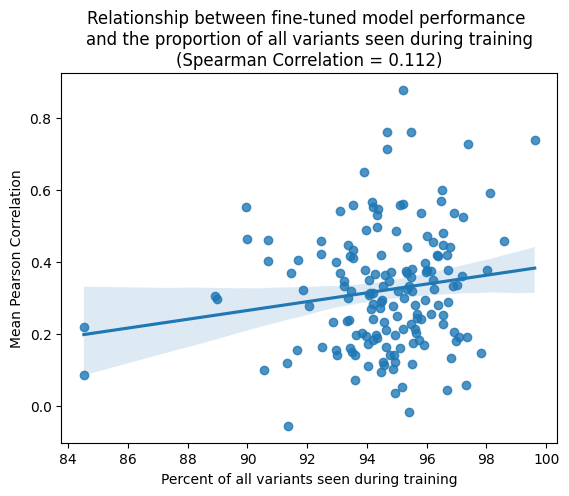

In [99]:
spr = spearmanr(random_split_gene_perf["Percent of all variants seen during training"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["Percent of all variants seen during training"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="Percent of all variants seen during training", 
            y="Mean Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand the proportion of all variants seen during training\n(Spearman Correlation = {spr.round(3)})")
plt.show()

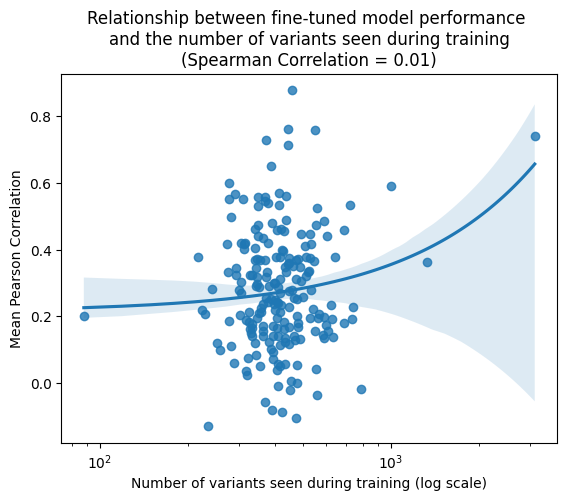

In [47]:
spr = spearmanr(random_split_gene_perf["Num variants seen during training"], 
                random_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(random_split_gene_perf["Num variants seen during training"], 
              random_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=random_split_gene_perf, 
            x="Num variants seen during training", 
            y="Mean Pearson Correlation", robust=True)
plt.xlabel("Number of variants seen during training (log scale)")
plt.title(f"Relationship between fine-tuned model performance \nand the number of variants seen during training\n(Spearman Correlation = {spr.round(3)})")
plt.xscale("log")
plt.show()

# Population split genes analyses

In [48]:
yri_split_gene_perf = gene_perf[gene_perf["gene_class"] == "yri_split"].copy().reset_index(drop=True)

## Performance vs. PrediXcan performance

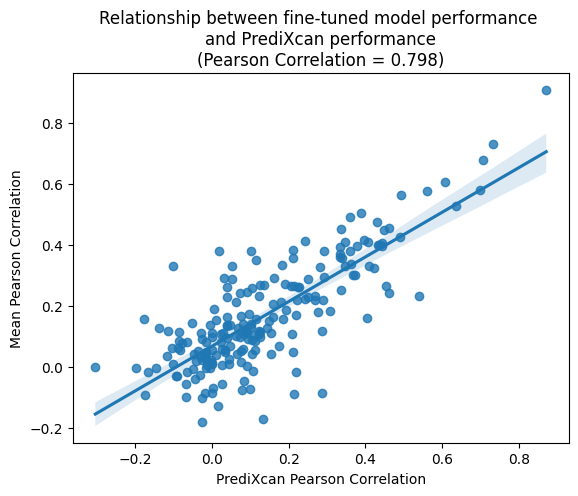

In [49]:
spr = spearmanr(yri_split_gene_perf["predixcan_Pearson"], 
                yri_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(yri_split_gene_perf["predixcan_Pearson"], 
              yri_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=yri_split_gene_perf, 
            x="predixcan_Pearson", 
            y="Mean Pearson Correlation")
plt.xlabel("PrediXcan Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand PrediXcan performance\n(Pearson Correlation = {pr.round(3)})")
plt.show()

## Performance vs. whether EUR top eQTL == YRI top eQTL

In [50]:
yri_split_gene_perf = yri_split_gene_perf.merge(GEUVADIS_COUNTS[["our_gene_name", "top_EUR_eqtl_rsid", "top_YRI_eqtl_rsid", "top_EUR_eqtl_distance", "top_YRI_eqtl_distance"]], 
                                                      left_on="gene", right_on="our_gene_name", how="inner").drop("our_gene_name", axis=1)
yri_split_gene_perf

,gene,gene_class,baseline_Pearson,predixcan_Pearson,finetuned_Pearson_regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,Mean Pearson Correlation,top_EUR_eqtl_rsid,top_YRI_eqtl_rsid,top_EUR_eqtl_distance,top_YRI_eqtl_distance
0,borcs7,yri_split,0.014520,0.441777,0.382340,0.438982,0.370680,0.397334,rs9527,NaN,9598.0,NaN
1,rtn4,yri_split,-0.190915,-0.004560,0.134631,0.087783,0.189967,0.137460,rs1822616,NaN,55879.0,NaN
2,borcs5,yri_split,0.003120,-0.015952,0.127085,0.105851,0.014372,0.082436,rs146170099,NaN,107772.0,NaN
3,epdr1,yri_split,-0.031474,-0.025755,-0.102745,-0.096989,-0.103741,-0.101158,rs7807193,NaN,211227.0,NaN
4,smug1,yri_split,0.037427,0.154789,0.143848,0.067110,0.120817,0.110591,rs2233921,NaN,6978.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,klhl7-dt,yri_split,-0.005762,0.732443,0.746198,0.719341,0.723480,0.729673,rs10233039,rs28646184,2209.0,5727.0
196,fbxl5,yri_split,0.024831,0.001551,0.015846,0.069256,0.078318,0.054473,rs35929560,NaN,221614.0,NaN
197,papss1,yri_split,-0.058410,0.193478,0.224284,0.120820,0.220313,0.188472,rs2158180,NaN,3071.0,NaN
198,hyal4,yri_split,0.090285,0.025782,-0.062955,-0.071133,-0.035435,-0.056508,rs75614337,NaN,198537.0,NaN


In [51]:
yri_split_gene_perf["Top EUR eQTL is the same as the top YRI eQTL"] = yri_split_gene_perf["top_EUR_eqtl_rsid"] == yri_split_gene_perf["top_YRI_eqtl_rsid"]

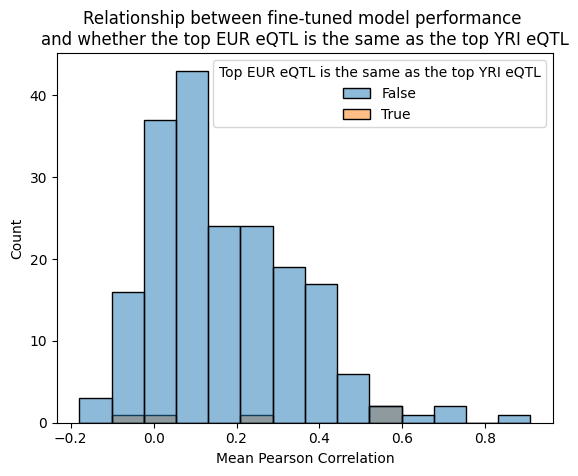

In [52]:
sns.histplot(data=yri_split_gene_perf, 
            hue="Top EUR eQTL is the same as the top YRI eQTL", 
            x="Mean Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand whether the top EUR eQTL is the same as the top YRI eQTL")
plt.show()

## Performance vs. percentage of variants observed during training

In [53]:
yri_split_gene_perf = yri_split_gene_perf.merge(gene_variant_stats[["gene"] + gene_variant_stats.columns[-5:].tolist()], on="gene", how="inner")
yri_split_gene_perf

,gene,gene_class,baseline_Pearson,predixcan_Pearson,finetuned_Pearson_regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,finetuned_Pearson_regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3,Mean Pearson Correlation,top_EUR_eqtl_rsid,top_YRI_eqtl_rsid,top_EUR_eqtl_distance,top_YRI_eqtl_distance,Top EUR eQTL is the same as the top YRI eQTL,Percent of all variants seen during training,Num variants seen during training,Percent of all variants only seen during testing,Num variants only seen during testing,Num variants
0,borcs7,yri_split,0.014520,0.441777,0.382340,0.438982,0.370680,0.397334,rs9527,NaN,9598.0,NaN,False,76.676385,263,23.323615,80,343
1,rtn4,yri_split,-0.190915,-0.004560,0.134631,0.087783,0.189967,0.137460,rs1822616,NaN,55879.0,NaN,False,67.105263,357,31.390977,167,532
2,borcs5,yri_split,0.003120,-0.015952,0.127085,0.105851,0.014372,0.082436,rs146170099,NaN,107772.0,NaN,False,65.868263,330,33.333333,167,501
3,epdr1,yri_split,-0.031474,-0.025755,-0.102745,-0.096989,-0.103741,-0.101158,rs7807193,NaN,211227.0,NaN,False,60.051546,233,35.309278,137,388
4,smug1,yri_split,0.037427,0.154789,0.143848,0.067110,0.120817,0.110591,rs2233921,NaN,6978.0,NaN,False,57.471264,200,41.379310,144,348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,klhl7-dt,yri_split,-0.005762,0.732443,0.746198,0.719341,0.723480,0.729673,rs10233039,rs28646184,2209.0,5727.0,False,62.623762,253,36.386139,147,404
196,fbxl5,yri_split,0.024831,0.001551,0.015846,0.069256,0.078318,0.054473,rs35929560,NaN,221614.0,NaN,False,65.439093,231,32.861190,116,353
197,papss1,yri_split,-0.058410,0.193478,0.224284,0.120820,0.220313,0.188472,rs2158180,NaN,3071.0,NaN,False,53.110048,222,46.172249,193,418
198,hyal4,yri_split,0.090285,0.025782,-0.062955,-0.071133,-0.035435,-0.056508,rs75614337,NaN,198537.0,NaN,False,63.302752,207,36.085627,118,327


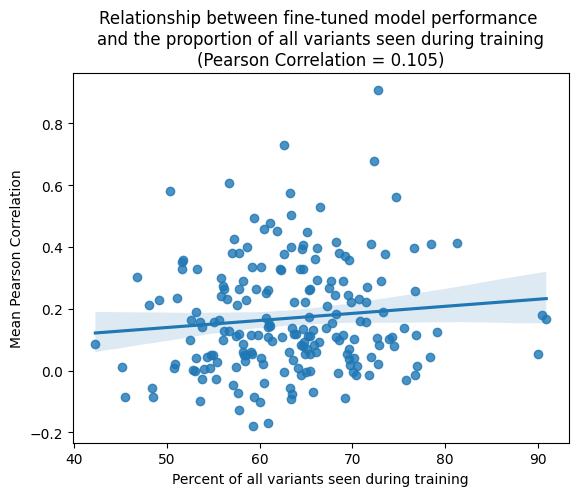

In [54]:
spr = spearmanr(yri_split_gene_perf["Percent of all variants seen during training"], 
                yri_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(yri_split_gene_perf["Percent of all variants seen during training"], 
              yri_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=yri_split_gene_perf, 
            x="Percent of all variants seen during training", 
            y="Mean Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand the proportion of all variants seen during training\n(Pearson Correlation = {pr.round(3)})")
plt.show()

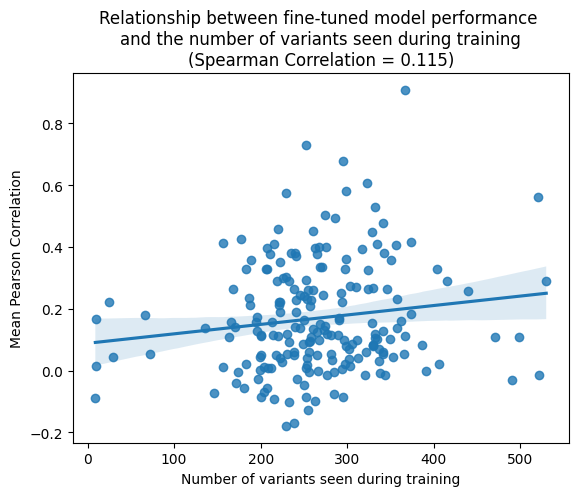

In [55]:
spr = spearmanr(yri_split_gene_perf["Num variants seen during training"], 
                yri_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(yri_split_gene_perf["Num variants seen during training"], 
              yri_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=yri_split_gene_perf, 
            x="Num variants seen during training", 
            y="Mean Pearson Correlation")
plt.xlabel("Number of variants seen during training")
plt.title(f"Relationship between fine-tuned model performance \nand the number of variants seen during training\n(Spearman Correlation = {spr.round(3)})")
# plt.xscale("log")
plt.show()

## Performance vs. percentage of variants observed only during testing

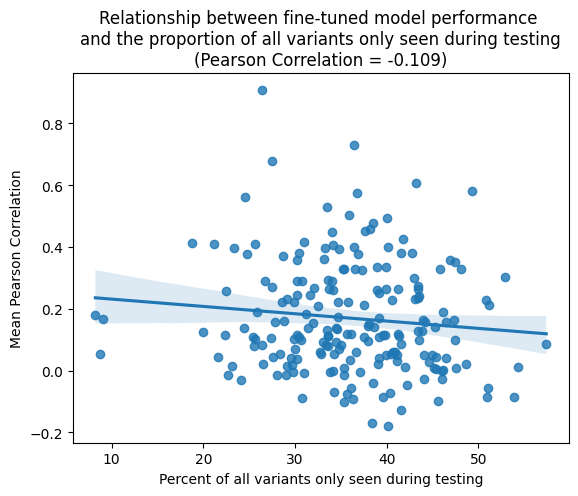

In [33]:
spr = spearmanr(yri_split_gene_perf["Percent of all variants only seen during testing"], 
                yri_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(yri_split_gene_perf["Percent of all variants only seen during testing"], 
              yri_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=yri_split_gene_perf, 
            x="Percent of all variants only seen during testing", 
            y="Mean Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand the proportion of all variants only seen during testing\n(Pearson Correlation = {pr.round(3)})")
plt.show()

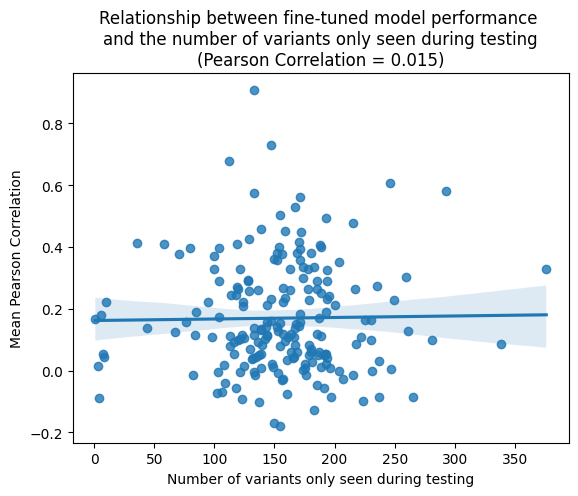

In [36]:
spr = spearmanr(yri_split_gene_perf["Num variants only seen during testing"], 
                yri_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(yri_split_gene_perf["Num variants only seen during testing"], 
              yri_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=yri_split_gene_perf, 
            x="Num variants only seen during testing", 
            y="Mean Pearson Correlation")
plt.xlabel("Number of variants only seen during testing")
plt.title(f"Relationship between fine-tuned model performance \nand the number of variants only seen during testing\n(Pearson Correlation = {pr.round(3)})")
# plt.xscale("log")
plt.show()

## Can fine-tuned model order populations by their expression even if it can’t order individuals within populations?

# Unseen genes analyses

In [37]:
unseen_split_gene_perf = gene_perf[gene_perf["gene_class"] == "unseen"].copy().reset_index(drop=True)

## Performance vs. Baseline performance

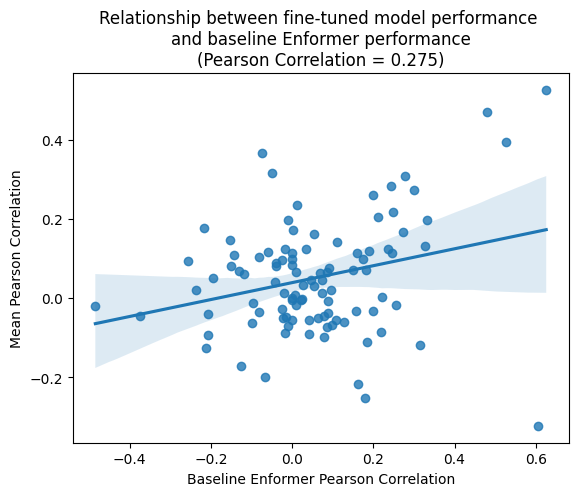

In [39]:
spr = spearmanr(unseen_split_gene_perf["baseline_Pearson"], 
                unseen_split_gene_perf["Mean Pearson Correlation"])[0]
pr = pearsonr(unseen_split_gene_perf["baseline_Pearson"], 
              unseen_split_gene_perf["Mean Pearson Correlation"])[0]

sns.regplot(data=unseen_split_gene_perf, 
            x="baseline_Pearson", 
            y="Mean Pearson Correlation")
plt.xlabel("Baseline Enformer Pearson Correlation")
plt.title(f"Relationship between fine-tuned model performance \nand baseline Enformer performance\n(Pearson Correlation = {pr.round(3)})")
plt.show()